# Tutorial 03: Energy equation

Apart from magnetisation and dynamics, energy equation must be defined for a micromagnetic system. In this tutorial, we explore how an energy equation can be specified in Ubermag.

Throughout this tutorial, for simplicity, we are going to use a one-dimensional sample (a chain of magnetic moments).

In [48]:
import discretisedfield as df
import micromagneticmodel as mm

%matplotlib inline

p1 = (0, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
n = (10, 1, 1)

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, n=n)

mesh.k3d()

Output()

### Zeeman energy

To demonstrate the effect of Zeeman energy we will apply an external magnetic field $H = 10^{6} \,\text{A}\,\text{m}^{-1}$ in the positive $z$-direction to the one-dimensional array of magnetic moments. For the initial magnetisation configuration, we will take the $(1, 0, 1)$ direction with $M_\text{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$.

In [63]:
H = (0, 0, 1e6)  # external magnetic field (A/m)
Ms = 8e6  # saturation magnetisation (A/m)

system = mm.System(name='zeeman')  # named micromagnetic system
system.energy = mm.Zeeman(H=H)  # define energy equation
system.m = df.Field(mesh, dim=3, value=(1, 0, 1), norm=Ms)  # define initial magnetisation

system.m.k3d_vectors(head_size=3)

Output()

After we defined our system, we can minimize its energy using `MinDriver`.

In [50]:
import oommfc as oc

md = oc.MinDriver()  # create energy minimisation driver
md.drive(system)  # run energy minimisation

system.m.k3d_vectors(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:03]... (1.9 s)


Output()

After applying the magnetic field, all magnetic moments align parallel to $\mathbf{H}$.

Now, we can change the direction of $\mathbf{H}$ to be in the negative $x$-direction and inspect the relaxed magnetisation state.

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:03]... (1.8 s)


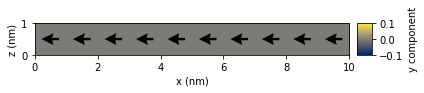

In [52]:
system.energy.zeeman.H = (-1e6, 0, 0)
md.drive(system)
system.m.plane('y').mpl()

## Uniaxial anisotropy

Let's assume our anisotropy axis is in the $(1, 0, 1)$ direction with $K = 6 \times 10^{6} \,\text{J}\,\text{m}^{-3}$ and the initial magnetisation is defined as

$$\mathbf{m} = \begin{cases} (-1, 0, -0.1) & \text{for } x \le 5 \,\text{nm} \\ (1, 0, 0.1) & \text{for } x > 5 \,\text{nm} \end{cases}$$

with $M_\text{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$.

In [55]:
system = mm.System(name='uniaxial_anisotropy')
system.energy = mm.UniaxialAnisotropy(K=6e6, u=(1, 0, 1))

def m_initial(pos):
    x, y, z = pos
    if x <= 5e-9:
        return (-1, 0, -0.1)
    else:
        return (1, 0, 0.1)

system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms)

system.m.k3d_vectors(head_size=3)

Output()

We can now relax the magnetisation.

In [56]:
md.drive(system)
system.m.k3d_vectors(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:04]... (2.2 s)


Output()

We see that in the relaxed state, all magnetic moments are aligned with the aniostropy axis. The initial configuration affects which orientation along the anisotropy direction is chosen.

## Exchange energy

To demonstrate how exchange energy affects the magnetisation configuration, we use $A = 8 \,\text{pJ}\,\text{m}^{-1}$ on a non-uniform magnetisation configuration.

In [57]:
system = mm.System(name='exchange')
system.energy = mm.Exchange(A=8e-12)

def m_initial(pos):
    x, y, z = pos
    if x <= 5e-9:
        return (0, 0, 1)  # z-direction
    else:
        return (1, 0, 0)  # x-direction
    
system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms)

system.m.k3d_vectors(head_size=3)

Output()

In [58]:
md.drive(system)
system.m.k3d_vectors(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:04]... (1.7 s)


Output()

## Dzyaloshinkii-Moriya energy

While the exchange interaction aims to align (neighbouring) magnetic moments parallel to each other, the Dzyaloshinskii-Moriya (DM) energy wants to align them perpendicular to each other.

There are two parameters that must be defined for Dzyaloshinskii-Moriya energy term. The first one is the DMI energy constant and the other is the crystalographic class. Crystalographic class can be: `T`, `O`, `Cnv`, or `D2d`.

Again, we demonstrate its effect by starting from a uniform configuration, with $D = 3\times10^{3} \,\text{J}\,\text{m}^{-2}$.

In [59]:
system = mm.System(name='dmi')
system.energy = mm.DMI(D=3e-3, crystalclass='T')
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)

md.drive(system)

system.m.k3d_vectors(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:07]... (1.7 s)


Output()

Now, we can change the crystallographic class and see what happens to the relaxed magnetisation.

In [60]:
system.energy.dmi.crystalclass = 'Cnv'
md.drive(system)
system.m.k3d_vectors(head_size=3)

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:09]... (1.7 s)


Output()

## Multiple energy terms

Multiple energy terms are added to the energy equation by applying a binary `+` operator.

As an example, we want to relax a one-dimensional chain of magnetic moments of length $L = 20 \,\text{nm}$ with 20 discretisation cells. The energy equation consists of:

- exchange energy with $A=1 \times 10^{-11} \,\text{J}\,\text{m}^{-1}$, and
- Dzyaloshinskii-Moriya energy with $D = 4\pi A/L \approx 6.28 \times 10^{-3} \,\text{J}\,\text{m}^{-2}$ and `T` crystal class.

The magnetisation saturation is $M_\mathrm{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$ and we start with a uniform magnetisation state.

In [68]:
A = 1e-11  # exchange energy constant (J/m)
D = 6.28e-3  # DMI energy constant (J/m**2)
Ms = 8e6 # Saturation magnetisation (A/m)

region = df.Region(p1=(0, 0, 0), p2=(20e-9, 1e-9, 1e-9))
mesh = df.Mesh(region=region, cell=(1e-9, 1e-9, 1e-9))
system = mm.System(name='exchange_and_DMI')
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T')
system.m = df.Field(mesh, dim=3, value=(0, 1, 1), norm=Ms)

md = oc.MinDriver()  # create energy minimisation driver
md.drive(system)

system.m.plane('y').k3d_vectors(color_field=system.m.z)

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:16]... (1.8 s)


Output()

We can also sample the magnetisation along the sample.

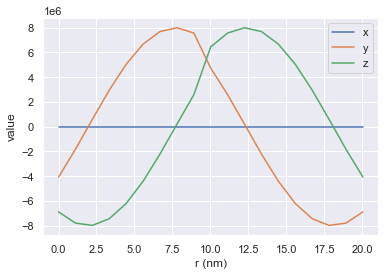

In [79]:
system.m.line(p1=system.m.mesh.region.pmin, p2=system.m.mesh.region.pmax, n=19).mpl()

## Exercise

Modify the following code in order to obtain a Bloch skyrmion in a disk.

Running OOMMF (ExeOOMMFRunner) [2020/04/29 09:31]... (1.8 s)


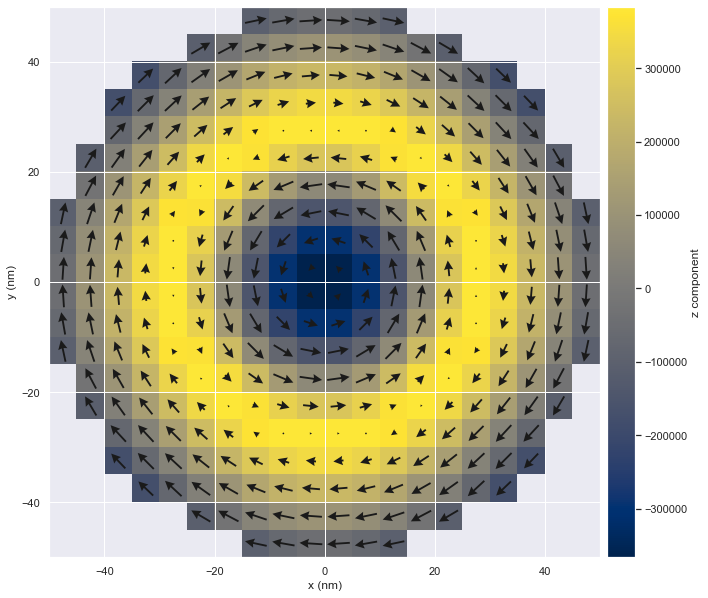

In [91]:
d = 100e-9
thickness = 5e-9
cell = 3*(5e-9,)

p1 = (-d/2, -d/2, 0)
p2 = (d/2, d/2, thickness)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)
system = mm.System(name='skyrmion')
system.energy = mm.Exchange(A=8.78e-12) + mm.DMI(D=1.58e-3, crystalclass='T') + mm.Demag()

def m_initial(point):
    x, y, z = point
    if x**2 + y**2 < (d/4)**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
def Ms_fun(point):
    x, y, z = point
    if x**2 + y**2 < (d/2)**2:
        return 3.84e5
    else:
        return 0
    
system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms_fun)

md = oc.MinDriver()
md.drive(system)

system.m.plane('z').mpl(figsize=(10, 10))